In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer
import warnings
warnings.filterwarnings("ignore")

In [18]:
!mkdir logs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘logs’: File exists


In [19]:
model_name = "few_shot_learning"
dataset_name = "cord"

In [20]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [21]:
dataset = load_dataset("katanaml/cord")

Repo card metadata block was not found. Setting CardData to empty.


In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
})

In [23]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'I-menu.cnt',
 'I-menu.discountprice',
 'I-menu.nm',
 'I-menu.num',
 'I-menu.price',
 'I-menu.sub_cnt',
 'I-menu.sub_nm',
 'I-menu.sub_price',
 'I-menu.unitprice',
 'I-sub_total.discount_price',
 'I-sub_total.etc',
 'I-sub_total.service_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-total.cashprice',
 'I-total.changeprice',
 'I-total.creditcardprice',
 'I-total.emoneyprice',
 'I-total.menuqty_cnt',
 'I-total.menutype_cnt',
 'I-total.total_etc',
 'I-total.total_price']

In [24]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

23

In [25]:
bert_tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [26]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

## BERT

In [12]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=bert_tokenizer
)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:01<00:00, 505.29it/s]


In [13]:
validation_dataset = ImageLayoutDataset(
    dataset['validation'],
    tokenizer= bert_tokenizer
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 516.90it/s]


In [14]:
device = "cuda"

In [16]:
n = len(train_dataset)
history= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

for i in range(8):
    num_samples = n//2**i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    bert = BertForTokenClassification\
        .from_pretrained(
            'bert-base-uncased', 
            num_labels = n_classes
        )
    
    bert.to(device)

    trainer = BertTrainer(
        bert
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history[num_samples] = trainer.history

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 800 samples


100%|██████████| 10/10 [04:11<00:00, 25.17s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 400 samples


100%|██████████| 10/10 [02:11<00:00, 13.17s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 200 samples


100%|██████████| 10/10 [01:11<00:00,  7.12s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 100 samples


100%|██████████| 10/10 [00:40<00:00,  4.08s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 50 samples


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 25 samples


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 12 samples


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training bert with 6 samples


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


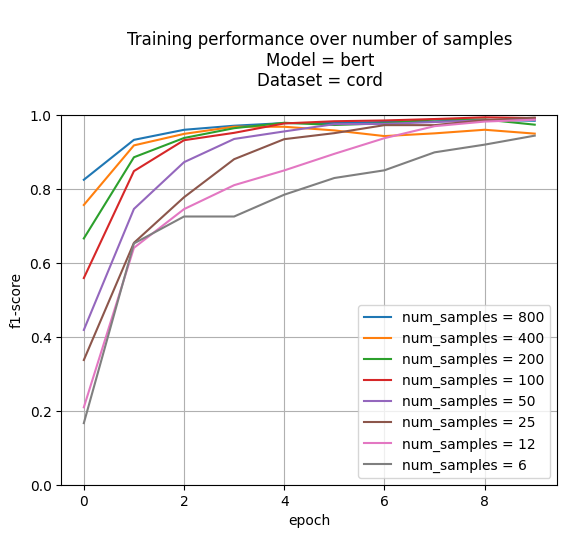

In [26]:
for k in history.keys():
    data = history[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

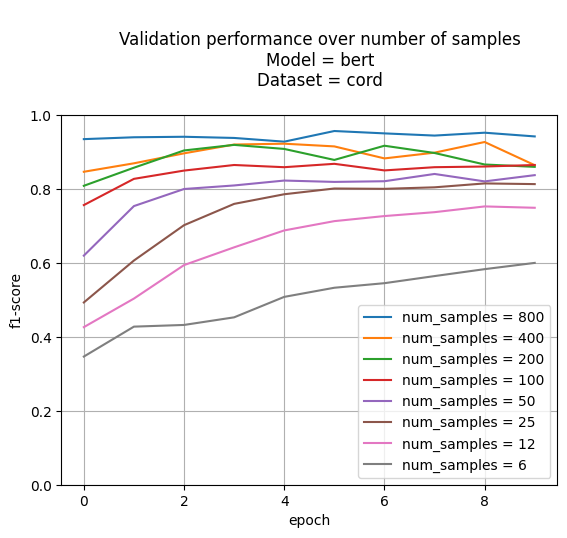

In [25]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## LayoutLM

In [27]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:01<00:00, 532.91it/s]


In [28]:
validation_dataset = ImageLayoutDataset(
    dataset['validation'],
    tokenizer= llm_tokenizer
)

100%|██████████| 100/100 [00:00<00:00, 540.80it/s]


In [29]:
device = "cuda"

In [30]:
n = len(train_dataset)
history_layoutlm= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

for i in range(8):
    num_samples = n//2**i

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes
        )
    
    layoutlm.to(device)

    trainer = BertTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history_layoutlm[num_samples] = trainer.history

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for k in history_layoutlm.keys():
    data = history_layoutlm[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

In [ ]:
for k in history_layoutlm.keys():
    data = history_layoutlm[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()